In [1]:
from analyze import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmcrameri import cm
import cmcrameri
from cycler import cycler, Cycler
from itertools import cycle

mpl.rc('image', cmap='cmc.batlow')
mpl.rc('text', usetex=True)


In [2]:
PROFILES_MAJOR = {
    "diatonic": TIV(0, tiv(Key("C")).vector, weights=TIV.weights_s),
    "k-k": TIV(0, TIV.from_chroma([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]).vector, weights=TIV.weights_s),
    # "temperley": TIV(0, TIV.from_chroma([0.748, 0.060, 0.488, 0.082, 0.670, 0.460, 0.096, 0.715, 0.104, 0.366, 0.057, 0.400]).vector, weights=TIV.weights_s),
}

PROFILES_MINOR = {
    "diatonic": TIV(0, tiv(Key("c")).vector, weights=TIV.weights_s),
    "k-k": TIV(0, TIV.from_chroma([6.33, 2.68, 3.52, 5.38, 2.6, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]).vector, weights=TIV.weights_s),
    # "temperley": TIV(0, TIV.from_chroma([0.712, 0.084, 0.474, 0.618, 0.049, 0.460, 0.105, 0.747, 0.404, 0.067, 0.133, 0.330]).vector, weights=TIV.weights_s),
}

PROFILES = {
    k: [*PROFILES_MAJOR[k].get_12_transposes(), *PROFILES_MINOR[k].get_12_transposes()] for k in PROFILES_MAJOR.keys()
}

In [3]:
def _key_distances_bern16(T):
    distances = {}
    for k, v in PROFILES.items():
        distances[k] = [TIV.cosine(T, p) for p in v]
    return distances

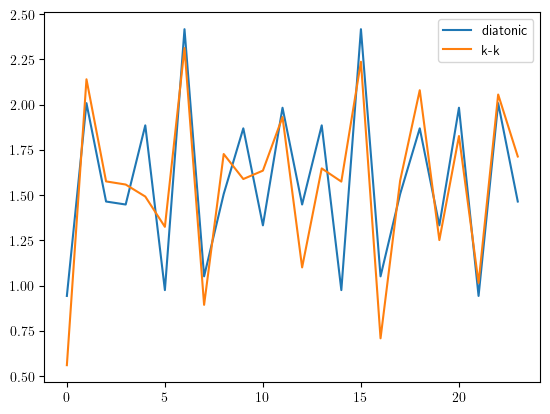

In [4]:
for k,d in _key_distances_bern16(tiv([0,4,7])).items():
    plt.plot(d, label=k)
plt.legend()

In [5]:
def _guess_key_profiles_bern16(T):
    distances = _key_distances_bern16(T)
    key_est = (
        {k: {
            "distance": np.min(d), 
            "key": Key(TIV.key_labels[np.argmin(d)])
        } for k, d in distances.items()})

    return key_est

In [6]:
_guess_key_profiles_bern16(tiv([0,4,7]))

{'diatonic': {'distance': 0.9428391347772114,
  'key': <music21.key.Key of C major>},
 'k-k': {'distance': 0.5603481710926148, 'key': <music21.key.Key of C major>}}

In [7]:
def guess_key_bern16(T):
    key_est = _guess_key_profiles_bern16(T)
    dists = [v["distance"] for v in key_est.values()]
    min_idx = np.argmin(dists)
    return key_est[list(key_est.keys())[min_idx]]["key"]

In [8]:
def key_approx_running(progression):
    alpha = 1
    P_tiv = [tiv(c) for c in progression]
    centers = []
    keys = []
    final_keys = []
    Tn = None
    n = 0
    for i in range(len(progression)):
        if i == 0:
            Tn = P_tiv[i]
        else:
            alpha = max(0.01, 1/(n+1))
            Tn = TIV(3, alpha * P_tiv[i].vector + (1 - alpha) * Tn.vector, weights=TIV.weights_s)
        key = guess_key_bern16(Tn)
        dist = scaled_cosine_dist_triad_key(P_tiv[i], tiv(key))
        # print(f"{i}: {key} ({dist})")
        if dist > 0.4 and n > 3:
            final_keys.extend([keys[-1]] * n)
            # print(f"Need a key change at {i}")
            Tn = P_tiv[i]
            n = 0
            key = guess_key_bern16(Tn)
            # print(f"\t{i}: {key} ({scaled_cosine_dist_triad_key(P_tiv[i], tiv(key))})")
        
        centers.append(Tn)
        keys.append(key)
        n += 1
    final_keys.extend([keys[-1]] * n)
    return keys, final_keys, centers

In [52]:
full_progression = list(read_progression(
        "../output/chords.txt", "../output/durations.txt", max_chords=600, scale_duration=True, force_octave=4
    ))
keys, final_keys, centers = key_approx_running(full_progression)
for k, kf in zip(keys, final_keys):
    print(f"{k}, {kf}")

A- major, a- minor
A- major, a- minor
a- minor, a- minor
a- minor, a- minor
C major, g minor
C major, g minor
c minor, g minor
g minor, g minor
G major, b minor
b minor, b minor
b minor, b minor
D major, b minor
b minor, b minor
d- minor, D- major
D- major, D- major
D- major, D- major
D- major, D- major
d minor, c minor
F major, c minor
F major, c minor
F major, c minor
c minor, c minor
c minor, c minor
e- minor, d- minor
G- major, d- minor
G- major, d- minor
G- major, d- minor
d- minor, d- minor
D- major, f minor
f minor, f minor
f minor, f minor
f minor, f minor
D major, A major
g- minor, A major
g- minor, A major
A major, A major
C major, g minor
C major, g minor
c minor, g minor
g minor, g minor
g minor, g minor
b- minor, f minor
D- major, f minor
f minor, f minor
f minor, f minor
d minor, A major
D major, A major
g- minor, A major
A major, A major
A major, A major
D- major, A- major
f minor, A- major
f minor, A- major
A- major, A- major
C major, G major
e minor, G major
e minor, G

k len: 600; kf len: 600


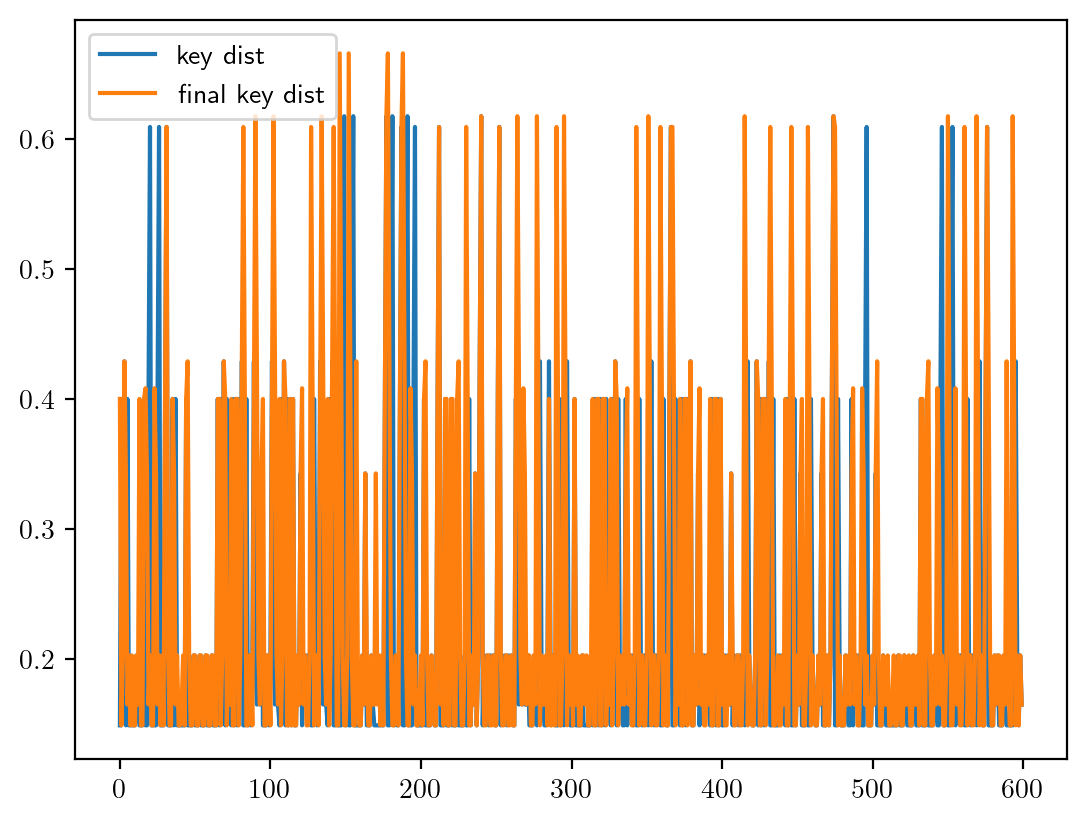

In [53]:
key_dists = [scaled_cosine_dist_triad_key(tiv(c), tiv(k)) for c, k in zip(full_progression, keys)]
plt.plot(key_dists, label="key dist")
final_key_dists = [scaled_cosine_dist_triad_key(tiv(c), tiv(k)) for c, k in zip(full_progression, final_keys)]
plt.plot(final_key_dists, label="final key dist")
plt.legend()
print(f"k len: {len(key_dists)}; kf len: {len(final_key_dists)}")


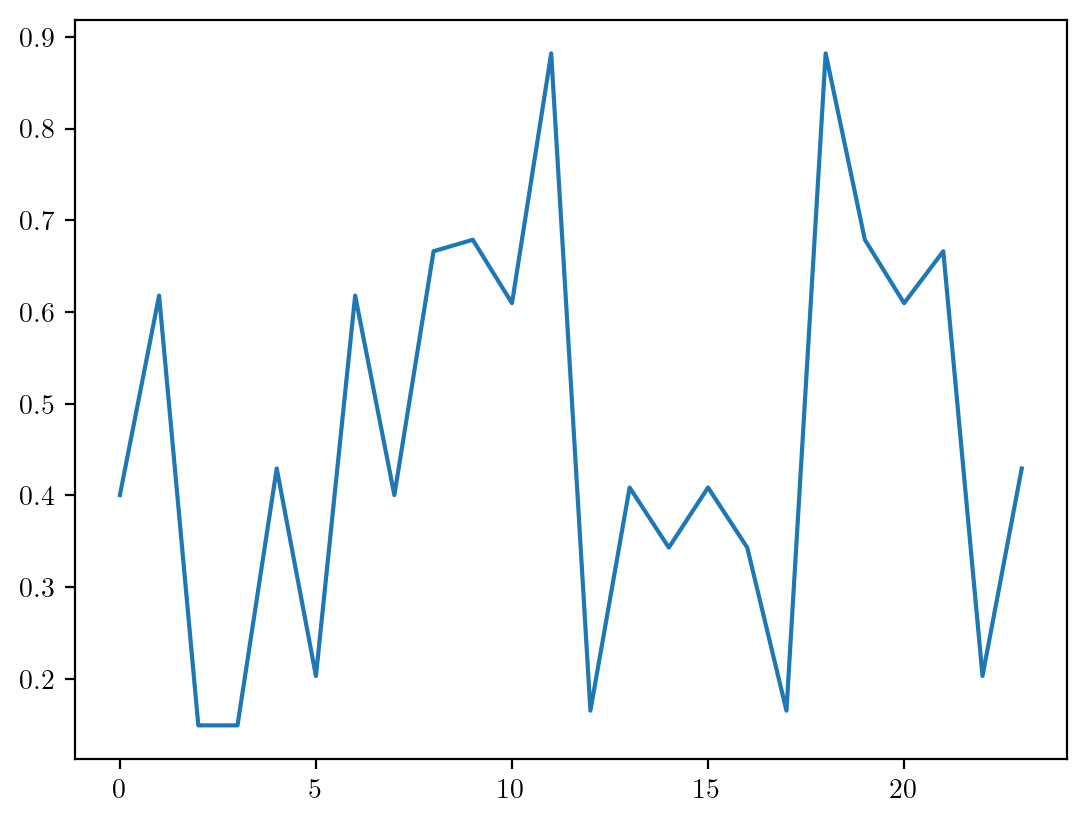

In [54]:
tonnetz_chords = [c for c in combinations(range(12), 3) if Chord(c).isMajorTriad() or Chord(c).isMinorTriad()]
max_dists = [key_unrelatedness(tiv(c), Key("C")) for c in tonnetz_chords]

plt.plot(max_dists)

In [55]:
def key_approx_window(progression, window=4):
    for i in range(len(progression) // window):
        s = Stream(progression[window*i : (window*i + window)])
        tivs = [tiv(c) for c in s]
        center = np.mean([t.vector for t in tivs], axis=0)
        k = guess_key_bern16(TIV(1, center, weights=TIV.weights_s))
        yield [k]*window
    if (i+1)*window < len(progression):
        s = Stream(progression[window*(i+1) :])
        tivs = [tiv(c) for c in s]
        center = np.mean([t.vector for t in tivs], axis=0)
        k = guess_key_bern16(TIV(1, center, weights=TIV.weights_s))
        yield [k]*(len(progression) - (i+1)*window + 1)


In [64]:
def key_approx_window_m21(progression, window=4):
    for i in range(len(progression) // window):
        s = Stream(progression[window*i : (window*i + window)])
        k = guess_key(s)
        yield [k]*window
    if (i+1)*window < len(progression):
        s = Stream(progression[window*(i+1) :])
        k = guess_key(s)
        yield [k]*(len(progression) - (i+1)*window + 1)

[<music21.key.Key of a- minor>, <music21.key.Key of a- minor>, <music21.key.Key of a- minor>, <music21.key.Key of a- minor>, <music21.key.Key of g minor>, <music21.key.Key of g minor>, <music21.key.Key of g minor>, <music21.key.Key of g minor>, <music21.key.Key of D major>, <music21.key.Key of D major>, <music21.key.Key of D major>, <music21.key.Key of D major>, <music21.key.Key of d- minor>, <music21.key.Key of d- minor>, <music21.key.Key of d- minor>, <music21.key.Key of d- minor>, <music21.key.Key of F major>, <music21.key.Key of F major>, <music21.key.Key of F major>, <music21.key.Key of F major>, <music21.key.Key of E- major>, <music21.key.Key of E- major>, <music21.key.Key of E- major>, <music21.key.Key of E- major>, <music21.key.Key of d- minor>, <music21.key.Key of d- minor>, <music21.key.Key of d- minor>, <music21.key.Key of d- minor>, <music21.key.Key of f minor>, <music21.key.Key of f minor>, <music21.key.Key of f minor>, <music21.key.Key of f minor>, <music21.key.Key of A m

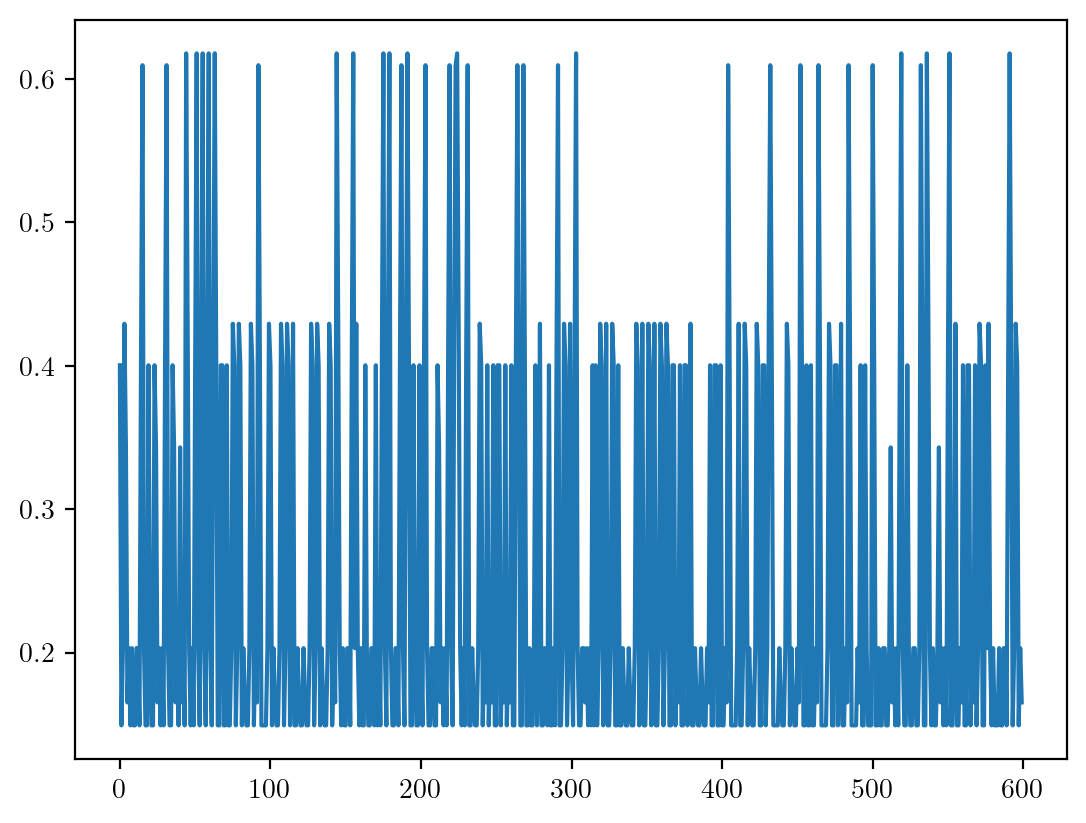

In [67]:
keys = [k for keys in key_approx_window(full_progression, window=4) for k in keys]
print(keys)
key_dists = [scaled_cosine_dist_triad_key(tiv(c), tiv(k)) for c, k in zip(full_progression, keys)]
print(f"avg key dist: {np.mean(key_dists)}")

plt.plot(key_dists, label="key dist")

[<music21.key.Key of E major>, <music21.key.Key of E major>, <music21.key.Key of E major>, <music21.key.Key of E major>, <music21.key.Key of c minor>, <music21.key.Key of c minor>, <music21.key.Key of c minor>, <music21.key.Key of c minor>, <music21.key.Key of D major>, <music21.key.Key of D major>, <music21.key.Key of D major>, <music21.key.Key of D major>, <music21.key.Key of C# major>, <music21.key.Key of C# major>, <music21.key.Key of C# major>, <music21.key.Key of C# major>, <music21.key.Key of B- major>, <music21.key.Key of B- major>, <music21.key.Key of B- major>, <music21.key.Key of B- major>, <music21.key.Key of A- major>, <music21.key.Key of A- major>, <music21.key.Key of A- major>, <music21.key.Key of A- major>, <music21.key.Key of f# minor>, <music21.key.Key of f# minor>, <music21.key.Key of f# minor>, <music21.key.Key of f# minor>, <music21.key.Key of F major>, <music21.key.Key of F major>, <music21.key.Key of F major>, <music21.key.Key of F major>, <music21.key.Key of D m

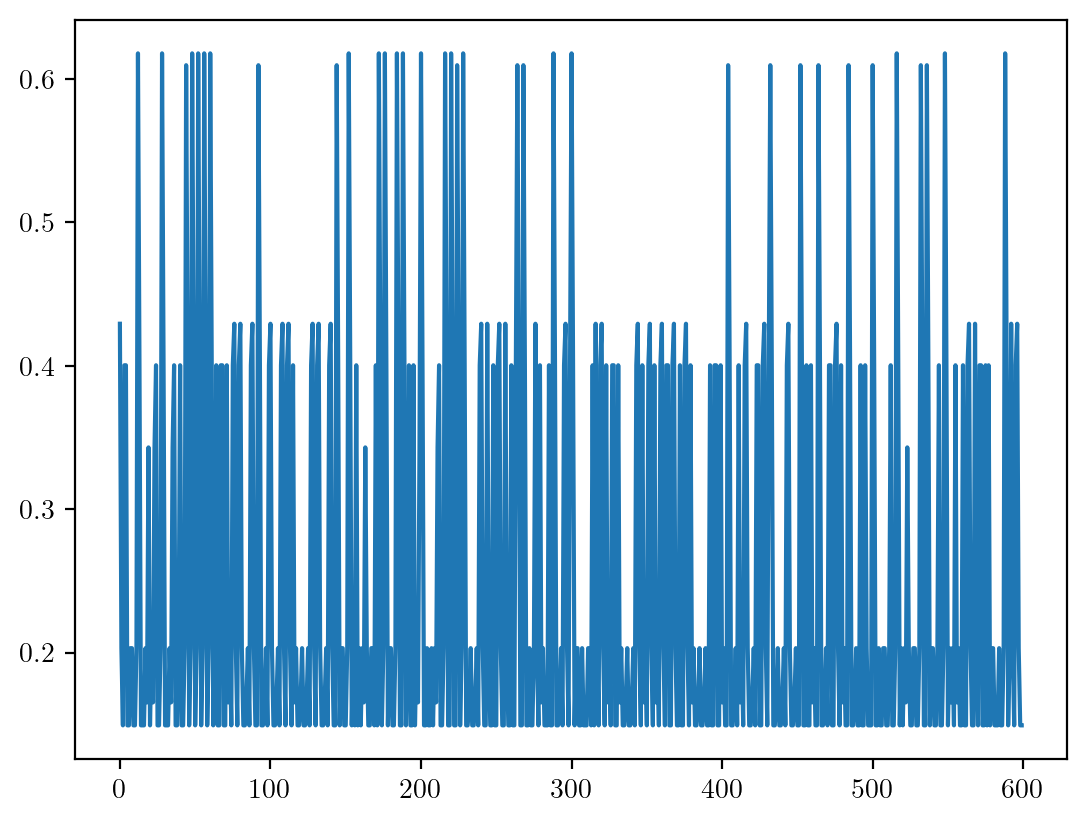

In [68]:
keys = [k for keys in key_approx_window_m21(full_progression, window=4) for k in keys]
print(keys)
key_dists = [scaled_cosine_dist_triad_key(tiv(c), tiv(k)) for c, k in zip(full_progression, keys)]
print(f"avg key dist: {np.mean(key_dists)}")

plt.plot(key_dists, label="key dist")

In [57]:
def plot_metrics(progression, window=4):
    fig, axes = plt.subplots(2, 2, layout='constrained', sharex=True, sharey=True, figsize=(6,4))
    colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    keys = [k for keys in key_approx_window_m21(progression, window=window) for k in keys]
    percept_dist = [perceptual_unrelatedness(tiv(c1), tiv(c2)) for c1, c2 in zip(progression[1:], progression[:-1])]
    percept_dist.insert(0, 0)
    key_dist = [key_unrelatedness(tiv(c), k) for c, k in zip(progression, keys)]
    hf_dist = [harmonic_function_unrelatedness(tiv(c), k) for c, k in zip(progression, keys)]
    vl_dist = [anti_voice_leading(c1, c2, k) for c1, c2, k in zip(progression[1:], progression[:-1], keys[1:])]
    vl_dist.insert(0, 0)
    print(f"percept_dist len: {len(percept_dist)}; key_dist len: {len(key_dist)}; hf_dist len: {len(hf_dist)}; vl_dist len: {len(vl_dist)}; progression len: {len(progression)}")
    axes[0,0].plot(range(len(progression)), percept_dist, color=colors[0], label="Perceptual distance")
    axes[0,0].legend()
    axes[0,1].plot(range(len(progression)), key_dist, color=colors[1], label="Key unrelatedness")
    axes[0,1].legend()
    axes[1,0].plot(range(len(progression)), hf_dist, color=colors[2], label="Harmonic function unrelatedness")
    axes[1,0].legend()
    axes[1,0].set_xlabel("Position in progression")
    axes[1,1].plot(range(len(progression)), vl_dist, color=colors[3], label="Voice leading distance")
    plt.legend()

    plt.xlabel("Position in progression")
    plt.ylim(-0.05, 1.05)
    plt.show()

In [118]:
def plot_windowed_metrics(progression, window=4):
    fig, axes = plt.subplots(3, 1, layout='constrained', sharex=True, sharey=True, figsize=(3,8))
    colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    keys = [k for keys in key_approx_window_m21(progression, window=window) for k in keys]
    percept_dist = np.asarray([0.] + [perceptual_unrelatedness(tiv(c1), tiv(c2)) for c1, c2 in zip(progression[1:], progression[:-1])])
    key_dist = np.asarray([key_unrelatedness(tiv(c), k) for c, k in zip(progression, keys)])
    # hf_dist = np.asarray([harmonic_function_unrelatedness(tiv(c), k) for c, k in zip(progression, keys)])
    vl_dist = np.asarray([0.] + [anti_voice_leading(c1, c2, k) for c1, c2, k in zip(progression[1:], progression[:-1], keys[1:])])
    print(f"percept_dist len: {len(percept_dist)}; key_dist len: {len(key_dist)}; vl_dist len: {len(vl_dist)}; progression len: {len(progression)}")
    start = [window*i for i in range(len(progression) // window)]
    percept_stdev = np.asarray([np.std(percept_dist[s:s+window]) for s in start])
    percept_mean = np.asarray([np.mean(percept_dist[s:s+window]) for s in start])
    key_stdev = np.asarray([np.std(key_dist[s:s+window]) for s in start])
    key_mean = np.asarray([np.mean(key_dist[s:s+window]) for s in start])
    # hf_dist = np.asarray([np.mean(hf_dist[s:s+window]) for s in start])
    vl_stdev = np.asarray([np.std(vl_dist[s:s+window]) for s in start])
    vl_mean = np.asarray([np.mean(vl_dist[s:s+window]) for s in start])
    axes[0].fill_between(range(len(percept_mean)), percept_mean - percept_stdev, percept_mean + percept_stdev, alpha=0.2, color=colors[0])
    axes[0].plot(percept_mean, color=colors[0], label="Perceptual distance")
    axes[0].legend()
    axes[1].fill_between(range(len(key_mean)), key_mean - key_stdev, key_mean + key_stdev, alpha=0.2, color=colors[1])
    axes[1].plot(key_mean, color=colors[1], label="Key unrelatedness")
    axes[1].legend()
    # axes[2].plot(hf_dist, color=colors[2], label="Harmonic function unrelatedness")
    # axes[2].legend()
    axes[2].fill_between(range(len(vl_mean)), vl_mean - vl_stdev, vl_mean + vl_stdev, alpha=0.2, color=colors[2])
    axes[2].plot(vl_mean, color=colors[2], label="Voice leading distance")
    plt.legend()
    
    plt.xlabel("Sub-progression position in progression")
    axes[0].set_title(f"Average over {window} chord sub-progressions", fontsize=12)

    plt.ylim(-0.05, 1.05)
    plt.show()

percept_dist len: 600; key_dist len: 600; hf_dist len: 600; vl_dist len: 600; progression len: 600


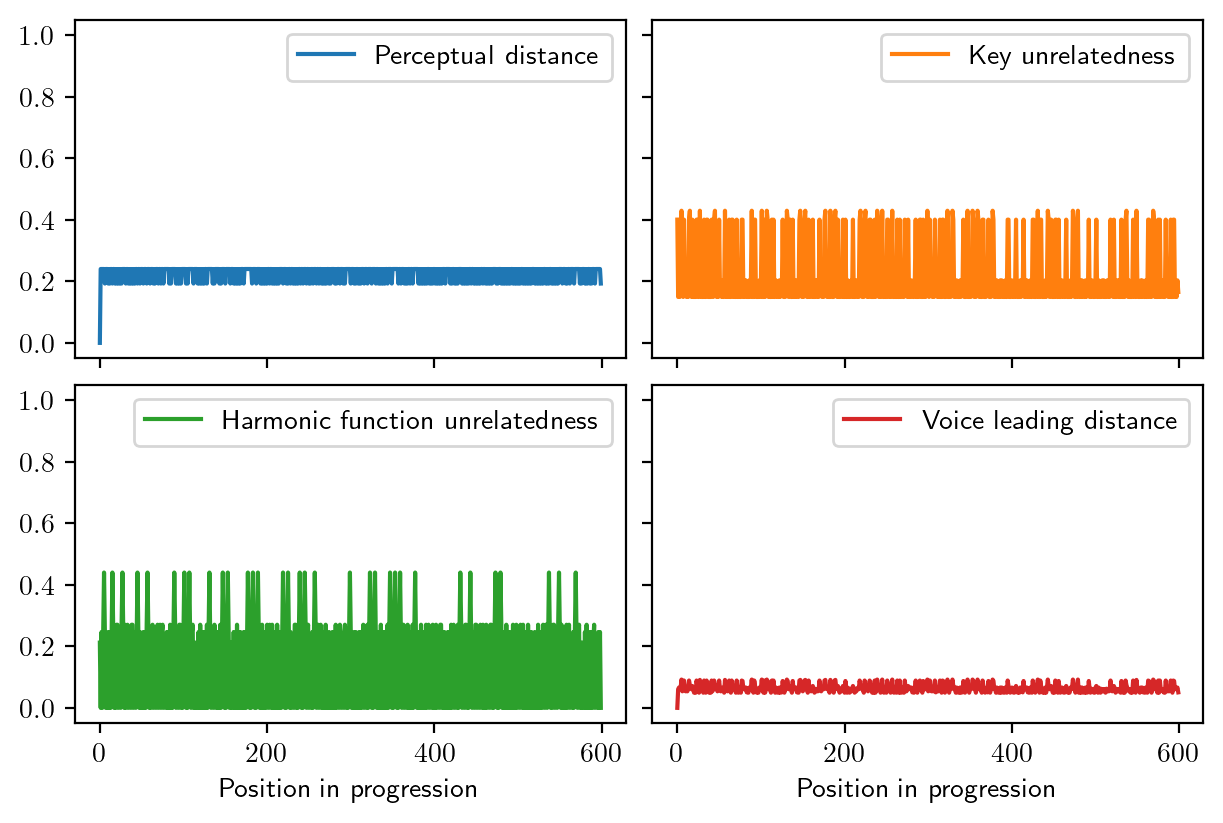

percept_dist len: 600; key_dist len: 600; hf_dist len: 600; vl_dist len: 600; progression len: 600


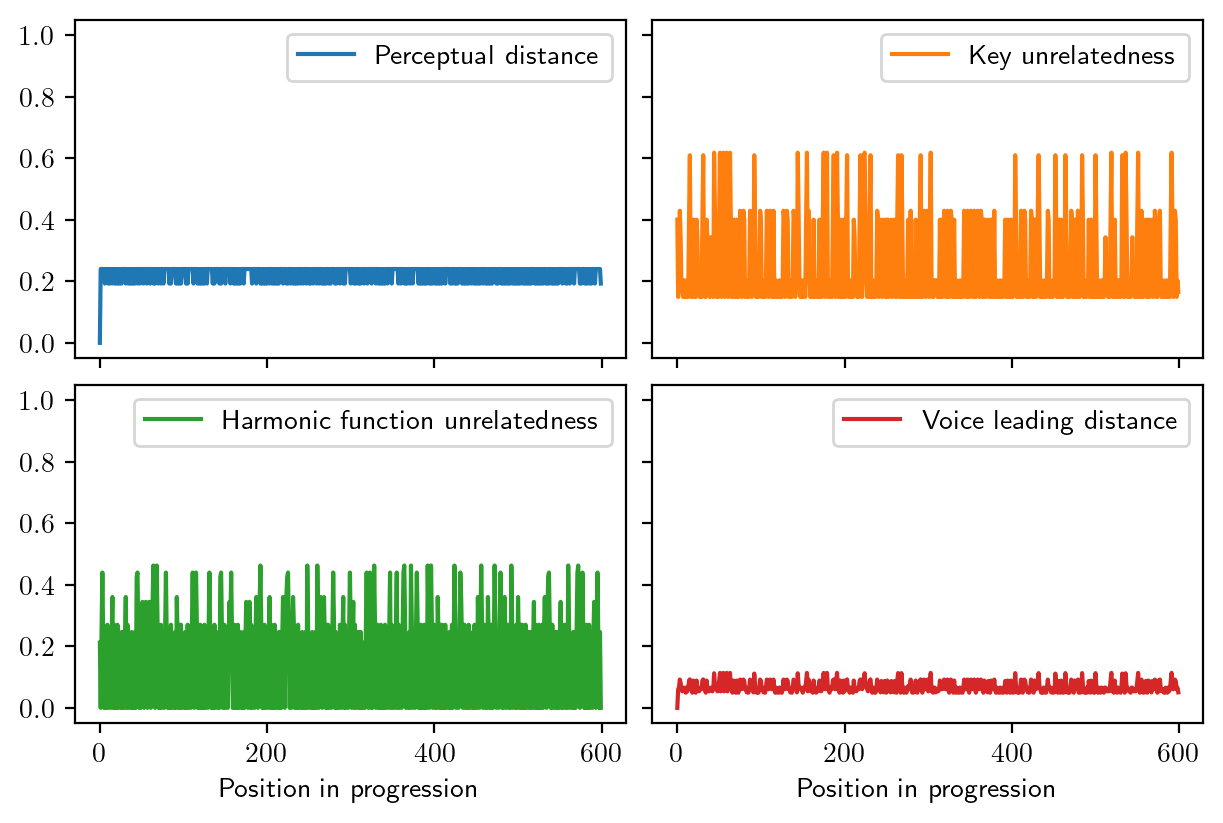

percept_dist len: 600; key_dist len: 600; hf_dist len: 600; vl_dist len: 600; progression len: 600


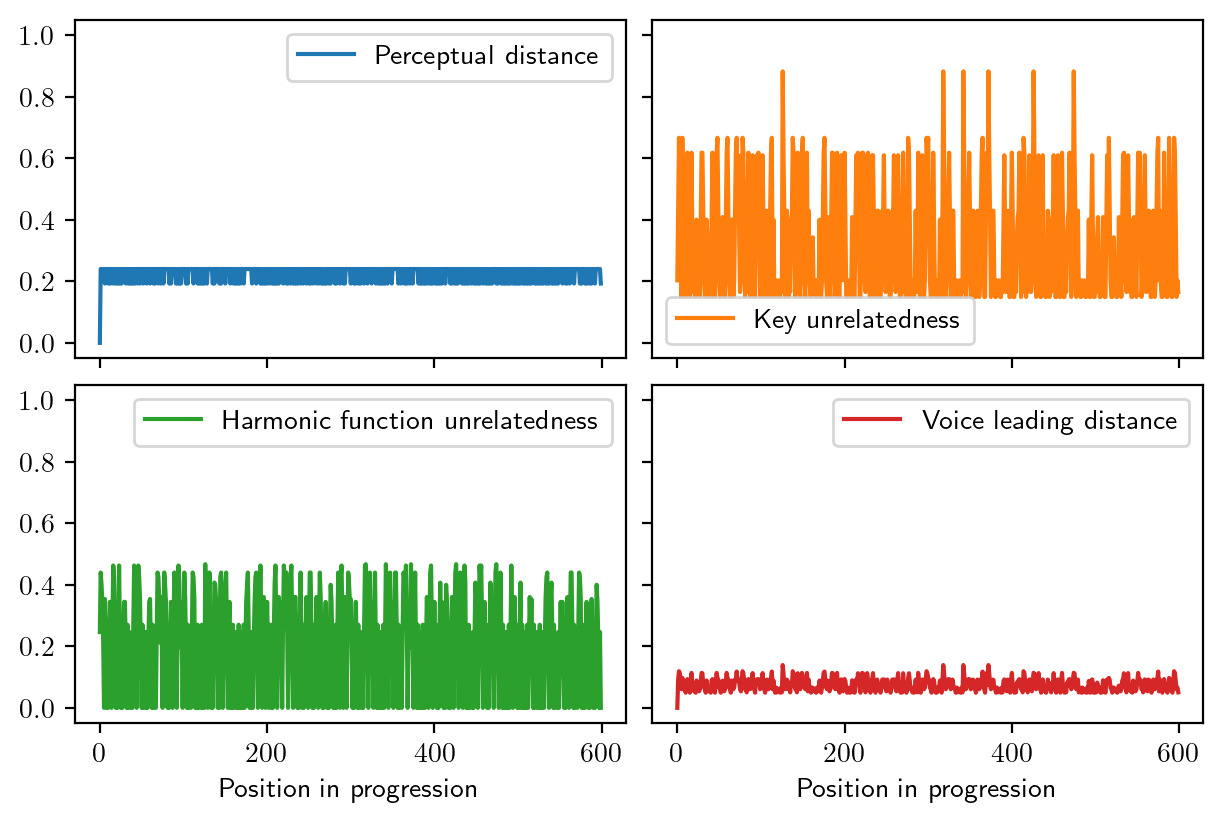

In [109]:
plot_metrics(full_progression, window=3)
plot_metrics(full_progression, window=4)
plot_metrics(full_progression, window=6)

percept_dist len: 600; key_dist len: 600; vl_dist len: 600; progression len: 600


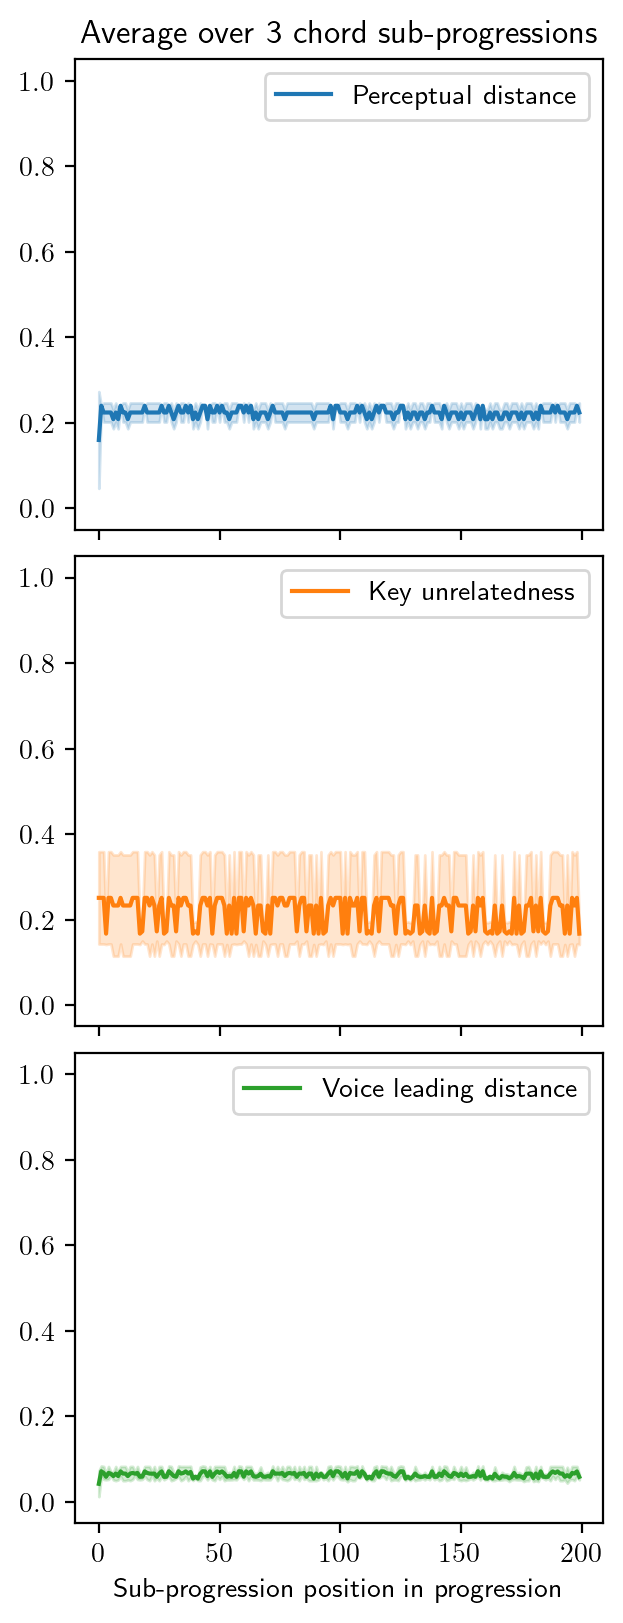

percept_dist len: 600; key_dist len: 600; vl_dist len: 600; progression len: 600


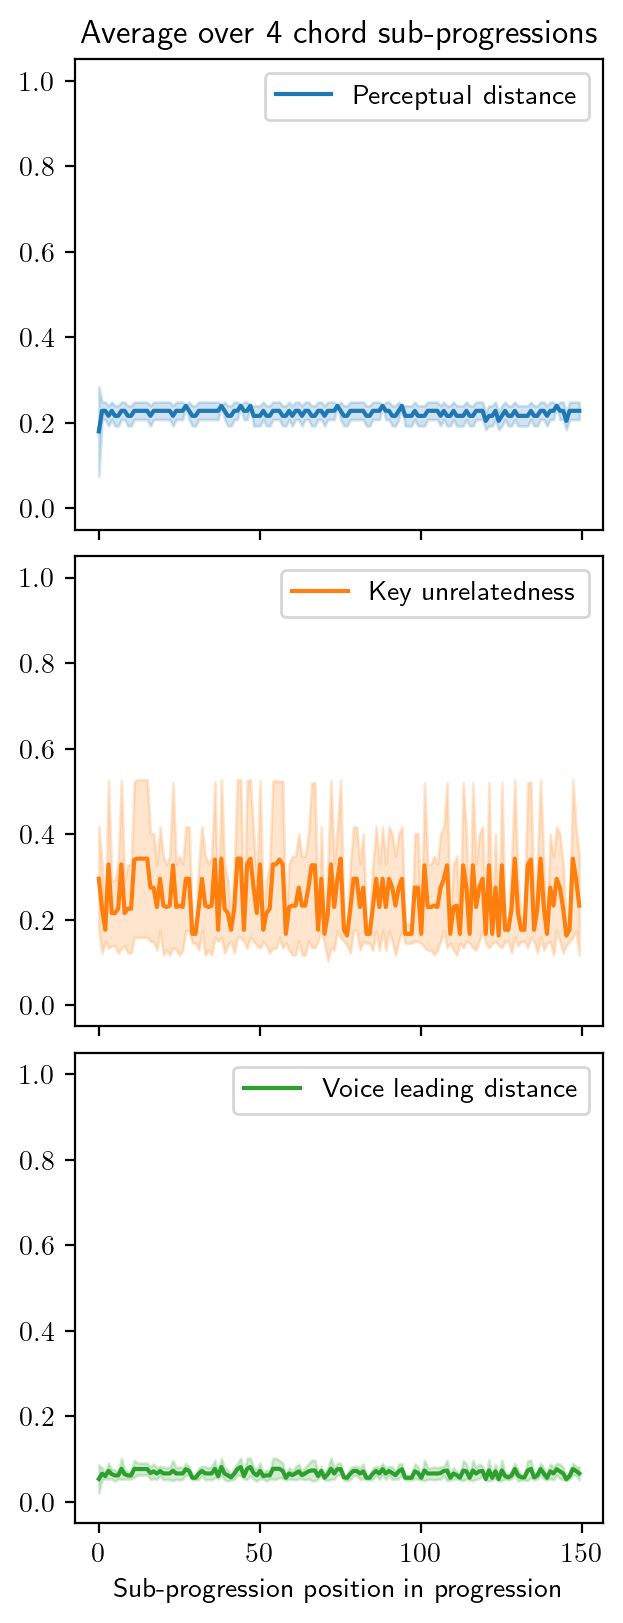

percept_dist len: 600; key_dist len: 600; vl_dist len: 600; progression len: 600


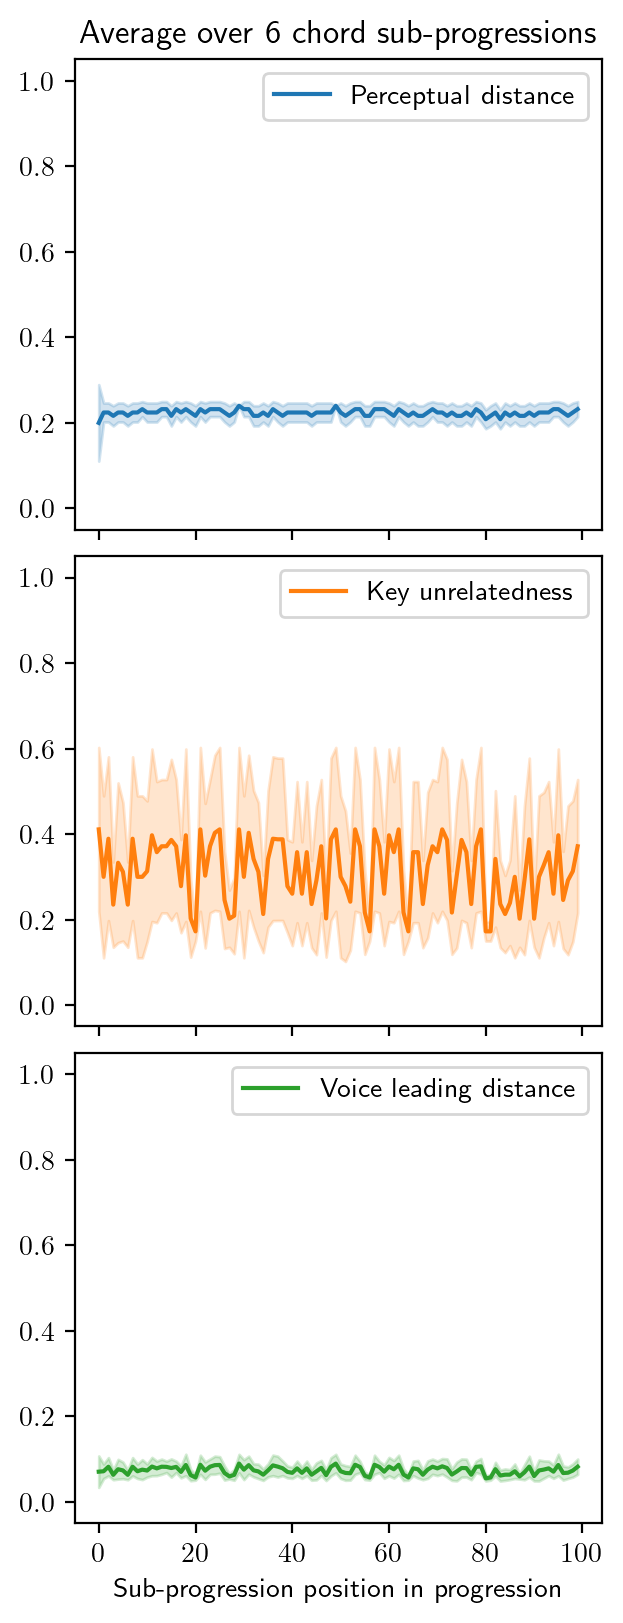

In [119]:
plot_windowed_metrics(full_progression, window=3)
plot_windowed_metrics(full_progression, window=4)
plot_windowed_metrics(full_progression, window=6)

In [104]:
tonnetz_chords = [c for c in combinations(range(12), 3) if Chord(c).isMajorTriad() or Chord(c).isMinorTriad()]
chords = [c for c in combinations(range(12), 3)]

percept_dist len: 600; key_dist len: 600; hf_dist len: 600; vl_dist len: 600; progression len: 600


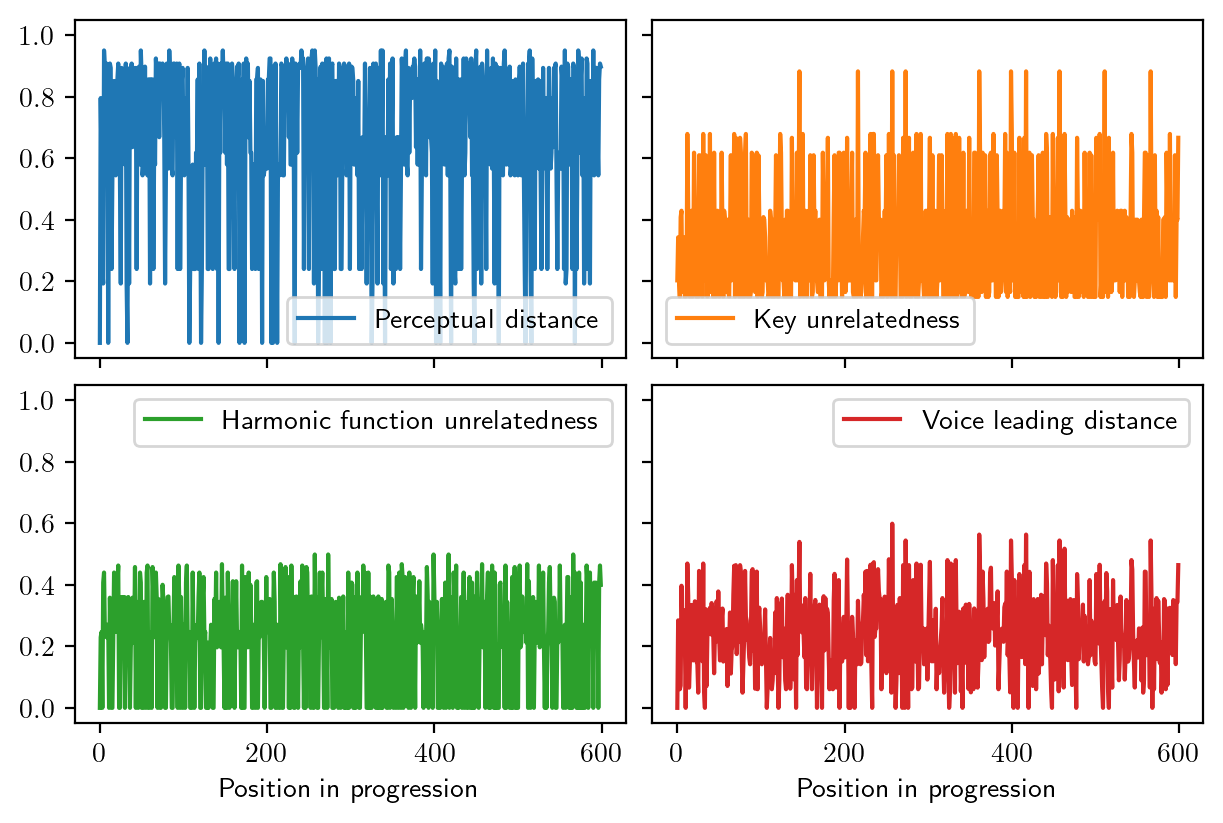

percept_dist len: 600; key_dist len: 600; vl_dist len: 600; progression len: 600


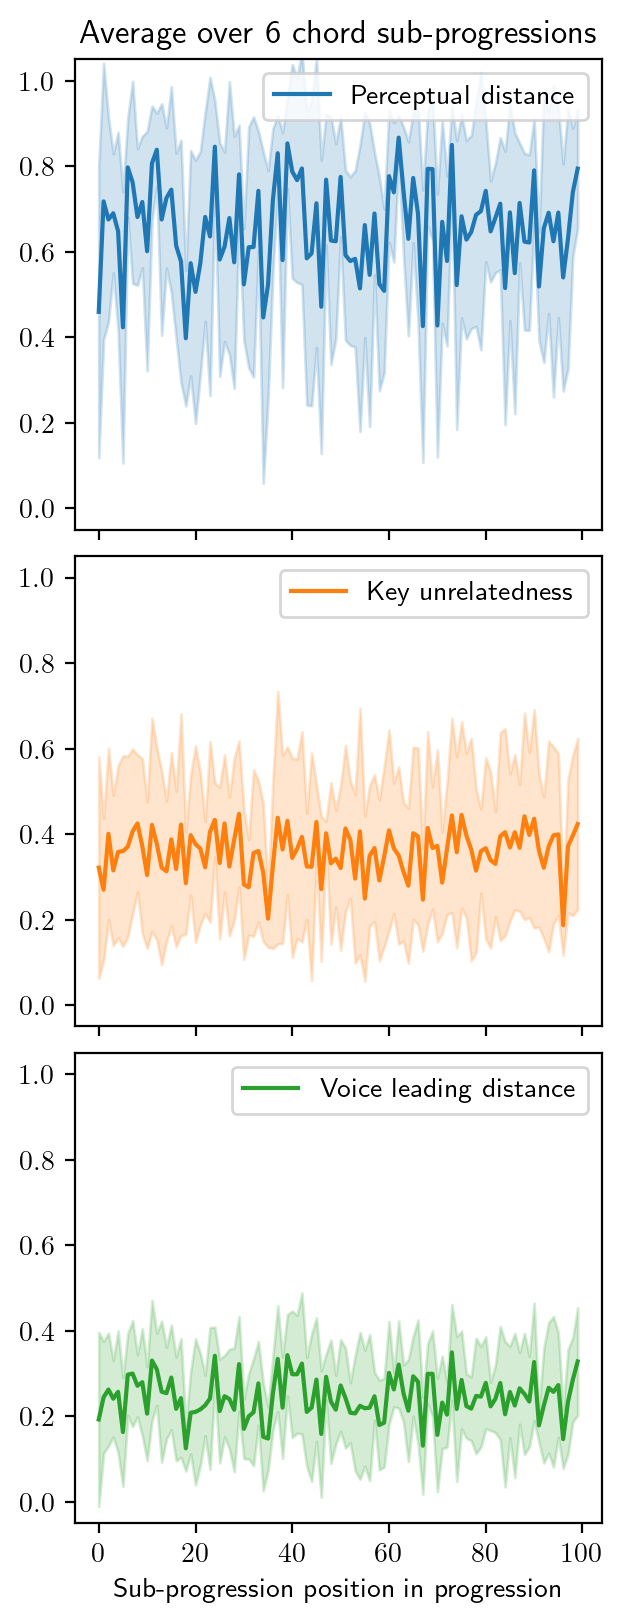

In [120]:
np.random.seed(42)
random_chords = Stream([Chord(tonnetz_chords[i]) for i in np.random.randint(0, len(tonnetz_chords), len(full_progression))])
plot_metrics(random_chords, window=4)
plot_windowed_metrics(random_chords, window=6)

percept_dist len: 600; key_dist len: 600; hf_dist len: 600; vl_dist len: 600; progression len: 600


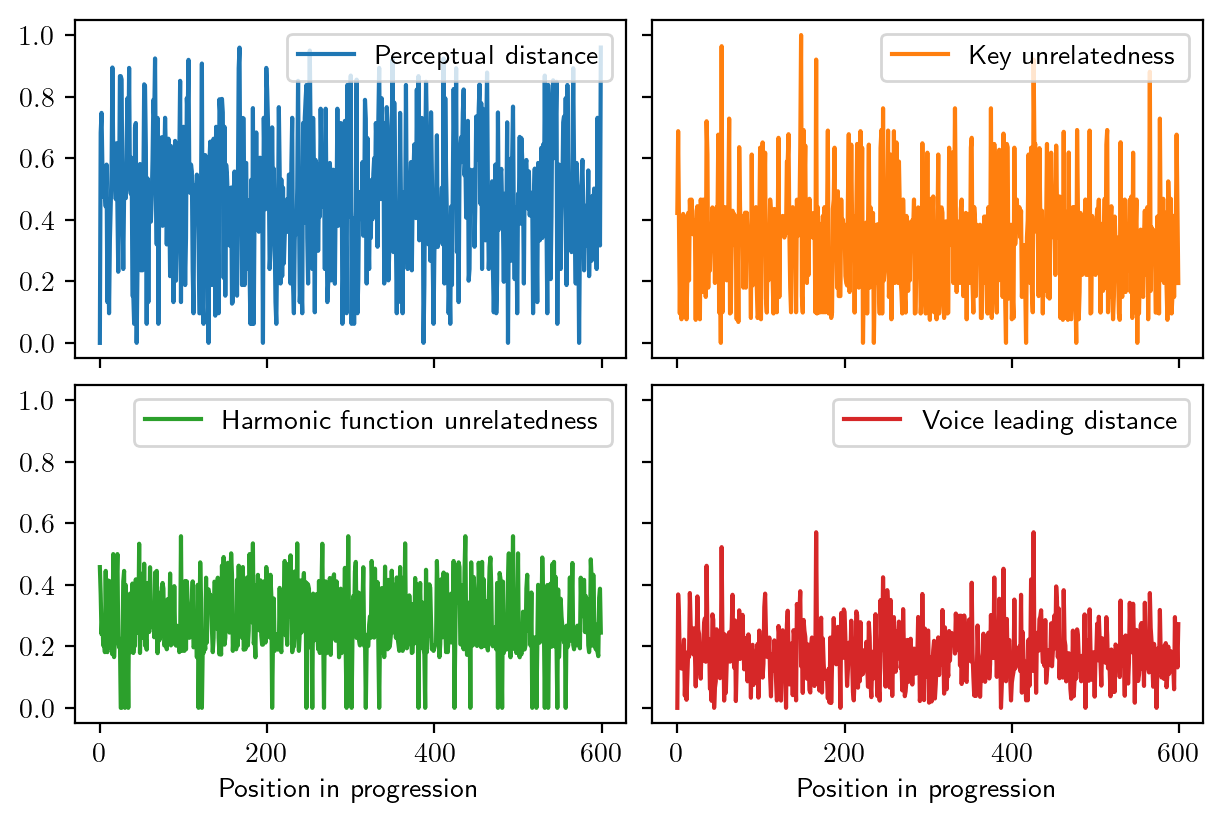

In [106]:
np.random.seed(42)
random_chords = Stream([Chord(chords[i]) for i in np.random.randint(0, len(chords), len(full_progression))])
plot_metrics(random_chords, window=4)
